In this notebook, the flow statistics of each lake inflows were calculated. And the correlation between the Q5,Q50,Q95 and drainage area was examined.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.signal
import datetime
from matplotlib import cm
#%matplotlib notebook

In [2]:
# Please make sure the working directory of the notebook is at the main folder
# If not, please us chdir function to change working directory
os.chdir('..')

In [3]:
pwd

'/home/xinchenh/work/LakeDrawdown_Repo/lake-drawdown'

In [4]:
from models.RRMPG.rrmpg.models import CemaneigeGR4J
from models.WDLake.WD_Lake import Lake
from tools.metrics import calc_nse, calc_kge
from tools.flowstats import flow_duration

In [5]:
lake_info = pd.read_csv("data/WD_Lakes.txt", sep = ",", dtype = {'Use_Gauge':str})
lake_info = lake_info.loc[lake_info['Lake'] != "Silver"]
lake_info = lake_info.loc[lake_info['Lake'] != "Wyman"]
lake_info = lake_info.loc[lake_info['Lake'] != "Cranberry Meadow"]
lake_info.head()

Lake        Lat           Lon Use_Gauge  Drainage Area_km2  \
0     Ashmere  42.433150     -73.08129  01174565             11.514   
1        Boon  42.405444  -71.50606155  01097300              5.110   
2  Brookhaven  42.258000     -72.18567  01175670              3.598   
3        Buel  42.162258  -73.26593399  01198000             14.190   
5    Garfield  42.190530     -73.20991  01198000             10.323   

   Elevation_m                                          bath_path  \
0       472.83    data/HS_Bathymetries/ashmere_1m_bathymetry1.tif   
1        56.76       data/HS_Bathymetries/boon_1m_bathymetry1.tif   
2       204.79  data/HS_Bathymetries/brookhaven_lake_1m_bathym...   
3       276.83       data/HS_Bathymetries/Buel_1m_bathymetry1.tif   
5       391.51   data/HS_Bathymetries/garfield_1m_bathymetry1.tif   

                              daymet_weather_path  \
0     data/Weather_Data/Daymet/Ashmere_daymet.csv   
1        data/Weather_Data/Daymet/Boon_daymet.csv   
2  data/Weather_Data/Daymet/Brookhaven_daymet.csv   
3        data/Weather_Data/Daymet/Buel_daymet.csv   
5    data/Weather_Data/Daymet/Garfield_daymet.csv   

                                        obs_rwl_path  obs_outflow_path  \
0  data/Obs_Lake_Levels/In-situ Water Level_Ashme...               NaN   
1  data/Obs_Lake_Levels/In-situ Water Level_Boon.csv               NaN   
2  data/Obs_Lake_Levels/In-situ Water Level_Brook...               NaN   
3  data/Obs_Lake_Levels/In-situ Water Level_Buel.csv               NaN   
5  data/Obs_Lake_Levels/In-situ Water Level_Garfi...               NaN   

   normal_stage_m  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
5             NaN

In [6]:
# Create an empty dict to save lake objects
lakes_list = [Lake(lname = lkname, 
           sim_date = pd.date_range('2010-01-01', '2020-12-30'), 
           val_date = pd.date_range('2015-10-31', '2018-06-01'), 
           wd_sim_date = pd.date_range('2015-11-01', '2018-08-01')) for lkname in lake_info['Lake'].values.ravel()]
lnames = list(lake_info['Lake'].values.ravel())
lakes = dict(zip(lnames, lakes_list))

============= Initiated a Lake object of Ashmere ===================
============= Initiated a Lake object of Boon ===================
============= Initiated a Lake object of Brookhaven ===================
============= Initiated a Lake object of Buel ===================
============= Initiated a Lake object of Garfield ===================
============= Initiated a Lake object of Goose ===================
============= Initiated a Lake object of Greenwater ===================
============= Initiated a Lake object of Hamilton ===================
============= Initiated a Lake object of Onota ===================
============= Initiated a Lake object of Otis ===================
============= Initiated a Lake object of Richmond ===================
============= Initiated a Lake object of Stockbridge ===================
============= Initiated a Lake object of Watatic ===================
============= Initiated a Lake object of Wickaboag ===================
============= Initiated a Lake o

In [7]:
lake_df = lake_info.set_index("Lake") # Find info by name

In [8]:
params_pool = pd.read_csv('data/HydroSimilarStations/parameters/Param_Metrics_RRMPG_CGR4J.txt',delimiter=',',index_col=0, dtype = {'Gauges':str})
params_pool.head()

Datum        Lat        Lon  Drainage_area_sqmile       CTG  \
Gauges                                                                       
01175670  191.841120  42.264814 -72.004242                  8.81  0.061642   
01181000  116.720112  42.237312 -72.895654                 94.00  0.170645   
01111500   54.626256  41.996487 -71.562008                 91.20  0.056554   
01097300   46.997112  42.512593 -71.404228                 12.80  0.102157   
01198000  210.113880  42.192908 -73.391231                 51.00  0.031988   

                Kf          x1        x2          x3        x4   NSE_cal  \
Gauges                                                                     
01175670  5.258350  239.824213 -0.485603  116.006261  1.642470  0.735255   
01181000  2.729069   94.151210  0.572261   50.715876  1.437586  0.486183   
01111500  5.644943  428.198252  0.040318  100.683382  2.016601  0.860473   
01097300  5.527557  422.341330 -1.219657  105.883857  2.089392  0.823000   
01198000  8.551404  114.354380 -0.724973  109.058609  1.324393  0.662829   

           NSE_val  NSE_total   KGE_cal   KGE_val  KGE_total  
Gauges                                                        
01175670  0.364704   0.683304  0.831180  0.627923   0.799954  
01181000  0.638502   0.511795  0.690882  0.793978   0.725558  
01111500  0.796452   0.851006  0.897560  0.861938   0.893322  
01097300  0.733398   0.814945  0.864736  0.697302   0.854759  
01198000  0.567330   0.651800  0.799327  0.722042   0.790977

# Loop Each Lake

In [9]:
lks = []
for lname in lnames:
    # for convinient, use lak to indicate the lake object
    lk = lakes[lname]
    print(lname)
    # ---------------Load Lake Informations -----------------
    lk.contributing_area = lake_df.loc[lname,'Drainage Area_km2'] * 1e6 # km^2 to m2
    lk.height = lake_df.loc[lname,'Elevation_m'] # meter
    lk.lat = lake_df.loc[lname,'Lat'] # Latitude
    bath_path = lake_df.loc[lname,'bath_path']
    weather_type = 'daymet'
    daymet_weather_path = lake_df.loc[lname,'daymet_weather_path']
    daymet_basin_weather_path = daymet_weather_path.replace(lname, lname + "_basin_mean")
    # pwl = 20 #  Surface water - Deepest bottom, for reference
    obs_rwl_path =  lake_df.loc[lname,'obs_rwl_path']
    obs_rwl = pd.read_csv(obs_rwl_path, index_col=0, parse_dates=True) # meter
    lk.val_date = obs_rwl.index
    # lk.wd_sim_date = obs_rwl.index
    lk.load_bathymetry(bath_path=bath_path, nSteps=200, unit = 'ft', plot_fit_curve = False) # Required
    pwl = lk.ewl - obs_rwl.max()[0]# Max water level will be regarded as the top level
    
    #pwl = 0.9 * lk.ewl 
    lk.load_pvol_dvol(pwl=pwl) # Required, load the reference water level for calculating relative water levels
    lk.load_observations(obs_rwl = obs_rwl, obs_outflow = [], obs_area = []) # Optional if you don't have any
    lk.load_weather(weather_type=weather_type, csv_path=daymet_weather_path) # Required, here we are using daymet
    lk.load_basin_weather(weather_type=weather_type, csv_path=daymet_basin_weather_path)
    
    #----------------- Connect CGR4J -------------------
    gauge_id = lake_df.loc[lname,'Use_Gauge']
    params = params_pool.loc[gauge_id, ['CTG', 'Kf', 'x1', 'x2', 'x3', 'x4']]
    params = params.to_dict() # The model receieve the parameters as dict
    model = CemaneigeGR4J()
    model.set_params(params)
    inflow_type = 'cgr4j'
    lk.connect_cgr4j(model=model, model_unit = 'cfsm', stochastic=False) # No stochastic
    lk.cgr4j_inflows = np.load("data/Inflow_Simulations/Stochastic/{lname}_inflows.npy".format(lname = lname))
    #param_path = 'data/Lake_Release_Parameters/{lname}_params.csv'.format(lname = lname)
    initial_wl = lk.pwl
    
    # I have calibrated and saved the parameter
    param_path = 'data/Lake_Release_Parameters/Historical_WD/{lname}_calibrated_bounded.csv'.format(lname = lname)
    param_df = pd.read_csv(param_path, index_col=0)
    
    lk.Simulate_WD_multiyears(param_df,
                              initial_wl, 
                              inflow_type = 'cgr4j', 
                              Qlim_unit = "m3s", 
                              a_or_ta = "ta")

Ashmere
============Reading Bathymetry=============
v_a loaded
h_v loaded
v_h loaded
Estimate pvol, dwl, dvol by input pwl
Relative water Level Observation->Observed storage->observed area
Parameters load
Parameters load
Parameters load
Parameters load
Boon
============Reading Bathymetry=============
v_a loaded
h_v loaded
v_h loaded
Estimate pvol, dwl, dvol by input pwl
Relative water Level Observation->Observed storage->observed area
Parameters load
Parameters load
Parameters load
Parameters load
Parameters load
Brookhaven
============Reading Bathymetry=============
v_a loaded
h_v loaded
v_h loaded
Estimate pvol, dwl, dvol by input pwl
Relative water Level Observation->Observed storage->observed area
Parameters load
Parameters load
Parameters load
Parameters load
Parameters load
Buel
============Reading Bathymetry=============
v_a loaded
h_v loaded
v_h loaded
Estimate pvol, dwl, dvol by input pwl
Relative water Level Observation->Observed storage->observed area
Parameters load
Paramet

FDC + average Qmin Qmax

# Calculate flow statistics

In [10]:
for i, n in enumerate(lnames):
    q5 = np.quantile(lakes[n].cgr4j_inflow.values.ravel(), q = 0.05)
    q50 = np.quantile(lakes[n].cgr4j_inflow.values.ravel(), q = 0.5)
    q95 = np.quantile(lakes[n].cgr4j_inflow.values.ravel(), q = 0.95)
    print("{ln}, Q5 = {q5}, Q50 = {q50}, Q95 = {q95}".format(ln = n, q5 = round(q5,2), q50 = round(q50,2), q95 = round(q95,2)))

Ashmere, Q5 = 0.03, Q50 = 0.16, Q95 = 0.93
Boon, Q5 = 0.01, Q50 = 0.05, Q95 = 0.21
Brookhaven, Q5 = 0.01, Q50 = 0.05, Q95 = 0.2
Buel, Q5 = 0.03, Q50 = 0.18, Q95 = 0.82
Garfield, Q5 = 0.03, Q50 = 0.14, Q95 = 0.68
Goose, Q5 = 0.03, Q50 = 0.15, Q95 = 0.78
Greenwater, Q5 = 0.01, Q50 = 0.06, Q95 = 0.37
Hamilton, Q5 = 0.19, Q50 = 0.77, Q95 = 2.47
Onota, Q5 = 0.06, Q50 = 0.34, Q95 = 1.57
Otis, Q5 = 0.11, Q50 = 0.62, Q95 = 4.19
Richmond, Q5 = 0.05, Q50 = 0.25, Q95 = 1.18
Stockbridge, Q5 = 0.06, Q50 = 0.37, Q95 = 1.55
Watatic, Q5 = 0.05, Q50 = 0.21, Q95 = 0.99
Wickaboag, Q5 = 0.1, Q50 = 0.57, Q95 = 2.42
Wyola, Q5 = 0.03, Q50 = 0.22, Q95 = 1.27


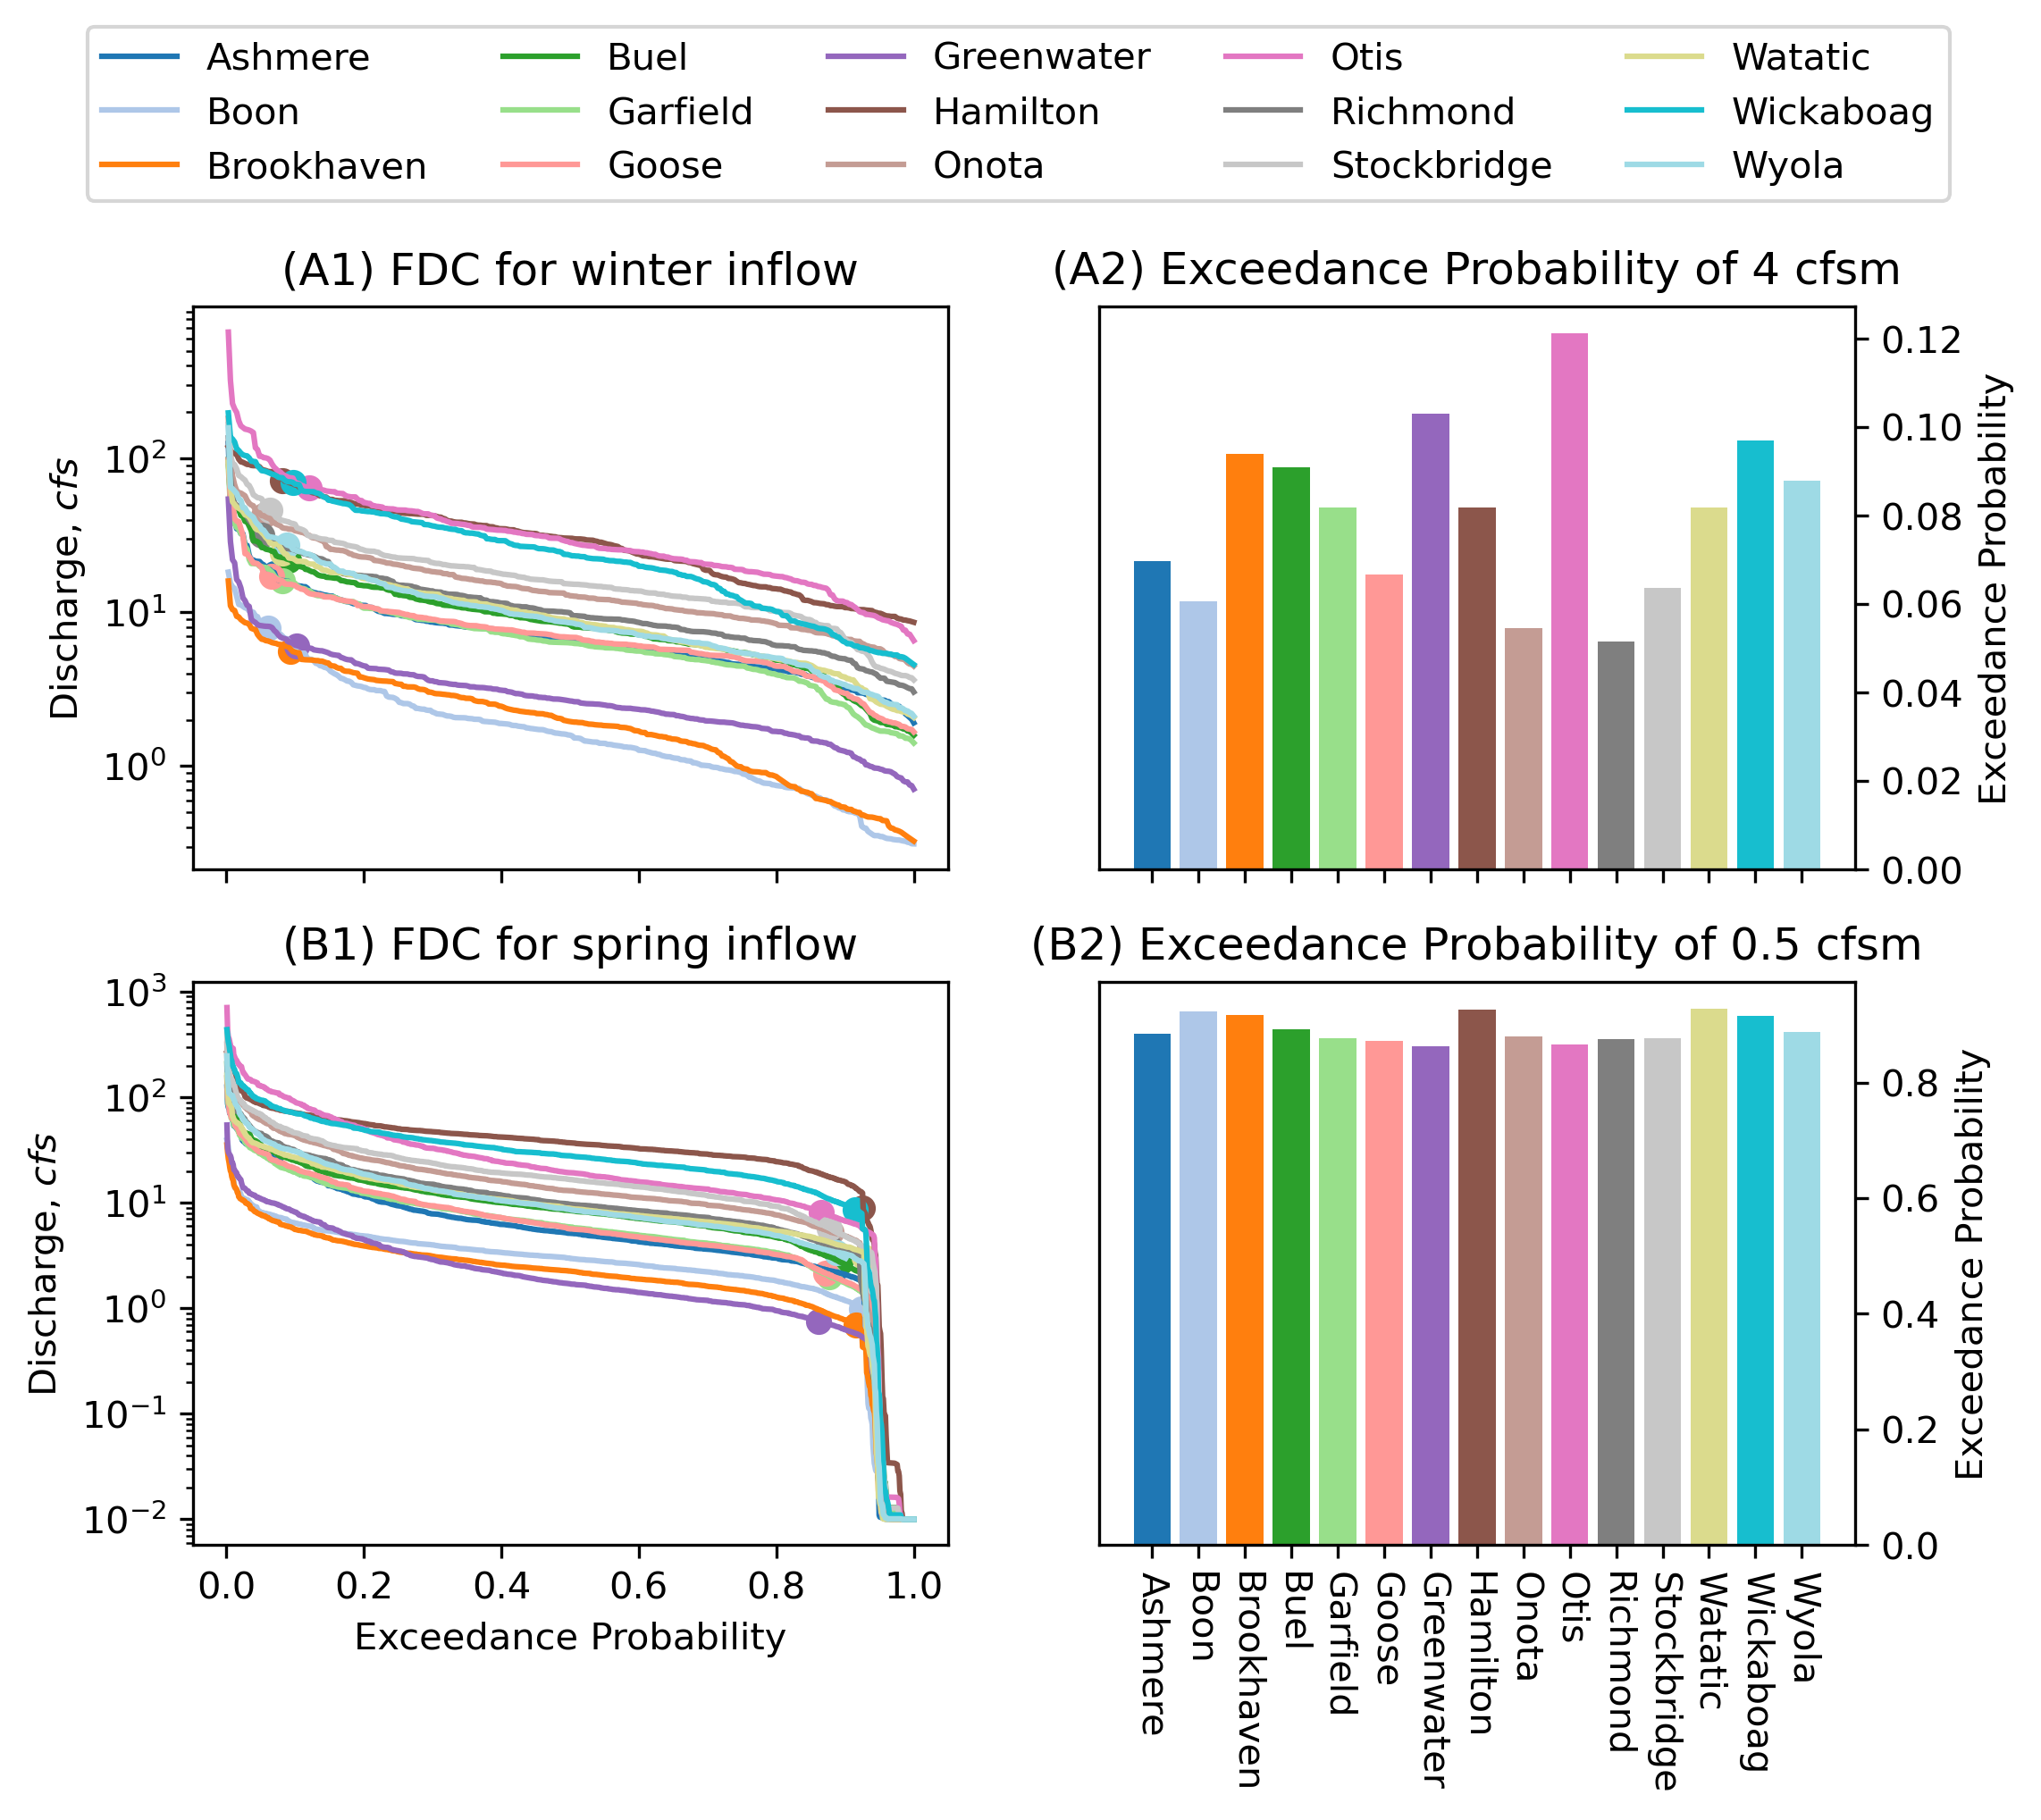

In [11]:
fig_fdc, axes = plt.subplots(2,2, figsize = (8,6), dpi = 300, sharex='col')
max_locs = []#4cfsm quantile
low_locs = []#0.5cfsm quantile

colors = [cm.tab20(x) for x in np.linspace(0,1,15)]

for i, n in enumerate(lnames):
    # calculate winter and spring flow
    winterflow = lakes[n].cgr4j_inflow.loc[lakes[n].cgr4j_inflow.index.month.isin([11])]*35.3147
    springflow = lakes[n].cgr4j_inflow.loc[lakes[n].cgr4j_inflow.index.month.isin([1,2,3])]*35.3147 + 0.01
    
    # plot flow duration curves
    winter_flow_stat = flow_duration(winterflow)
    spring_flow_stat = flow_duration(springflow)
    axes[0,0].plot(winter_flow_stat, 
                   label = n, 
                   color = colors[i])
    axes[1,0].plot(spring_flow_stat, 
                   label = n, 
                   color = colors[i])
    
    # calculate where is the 4cfsm and 0.5cfsm. What's the exceedance probability of these two values
    max_flow = 4 * lakes[n].contributing_area * 3.861E-7 # 4cfsm
    low_flow = 0.5 * lakes[n].contributing_area * 3.861E-7 # 0.5cfsm
    try:
        max_loc = 1 - np.argwhere(winterflow.sort_values('inflow').values.ravel() > max_flow)[0][0]/len(winterflow)# calculate where is the 4cfsm
    except:
        max_loc = 0
    try:
        low_loc = 1 - np.argwhere(springflow.sort_values('inflow').values.ravel() > low_flow)[0][0]/len(springflow)# calculate where is the 4cfsm
    except:
        low_loc = 0
        
    axes[0,0].scatter(max_loc, max_flow, color = colors[i], 
                      #label = n
                      )
    axes[1,0].scatter(low_loc, low_flow, color = colors[i], 
                      #label = n
                      )
    
    max_locs.append(max_loc)
    low_locs.append(low_loc)
    
# plot bar  plot of the quantile of the 4cfsm and 0.5cfsm
axes[0,1].bar(x = lnames, height = max_locs, color = colors)
axes[1,1].bar(x = lnames, height = low_locs, color = colors)
axes[0,1].set_title('(A2) Exceedance Probability of 4 cfsm')
axes[1,1].set_title('(B2) Exceedance Probability of 0.5 cfsm')
axes[0,1].yaxis.tick_right()
axes[0,1].set_ylabel('Exceedance Probability')
axes[0,1].yaxis.set_label_position("right")
axes[1,1].yaxis.tick_right()
axes[1,1].set_ylabel('Exceedance Probability')
axes[1,1].yaxis.set_label_position("right")

axes[1,1].set_xticks(lnames)
axes[1,1].set_xticklabels(lnames, rotation = -90)

axes[0,0].set_yscale('log')
axes[1,0].set_yscale('log')
axes[0,0].set_ylabel('Discharge, $cfs$')
axes[1,0].set_ylabel('Discharge, $cfs$')
axes[1,0].set_xlabel('Exceedance Probability')
axes[0,0].set_title('(A1) FDC for winter inflow')
axes[1,0].set_title('(B1) FDC for spring inflow')

# legend
handles, labels = axes[0,0].get_legend_handles_labels()
fig_fdc.legend(handles, labels, 
                  loc='center', bbox_to_anchor=(0.51, 1),
                  #frameon = False, 
                  fancybox = True,
                  ncol = 5
                 )

In [12]:
# fig_fdc.savefig("docs/paper_1/inflow_summary_statistics/fdc_winter_spring.pdf", bbox_inches='tight')

Not talk about 4cfsm and 0.5cfsm in this section

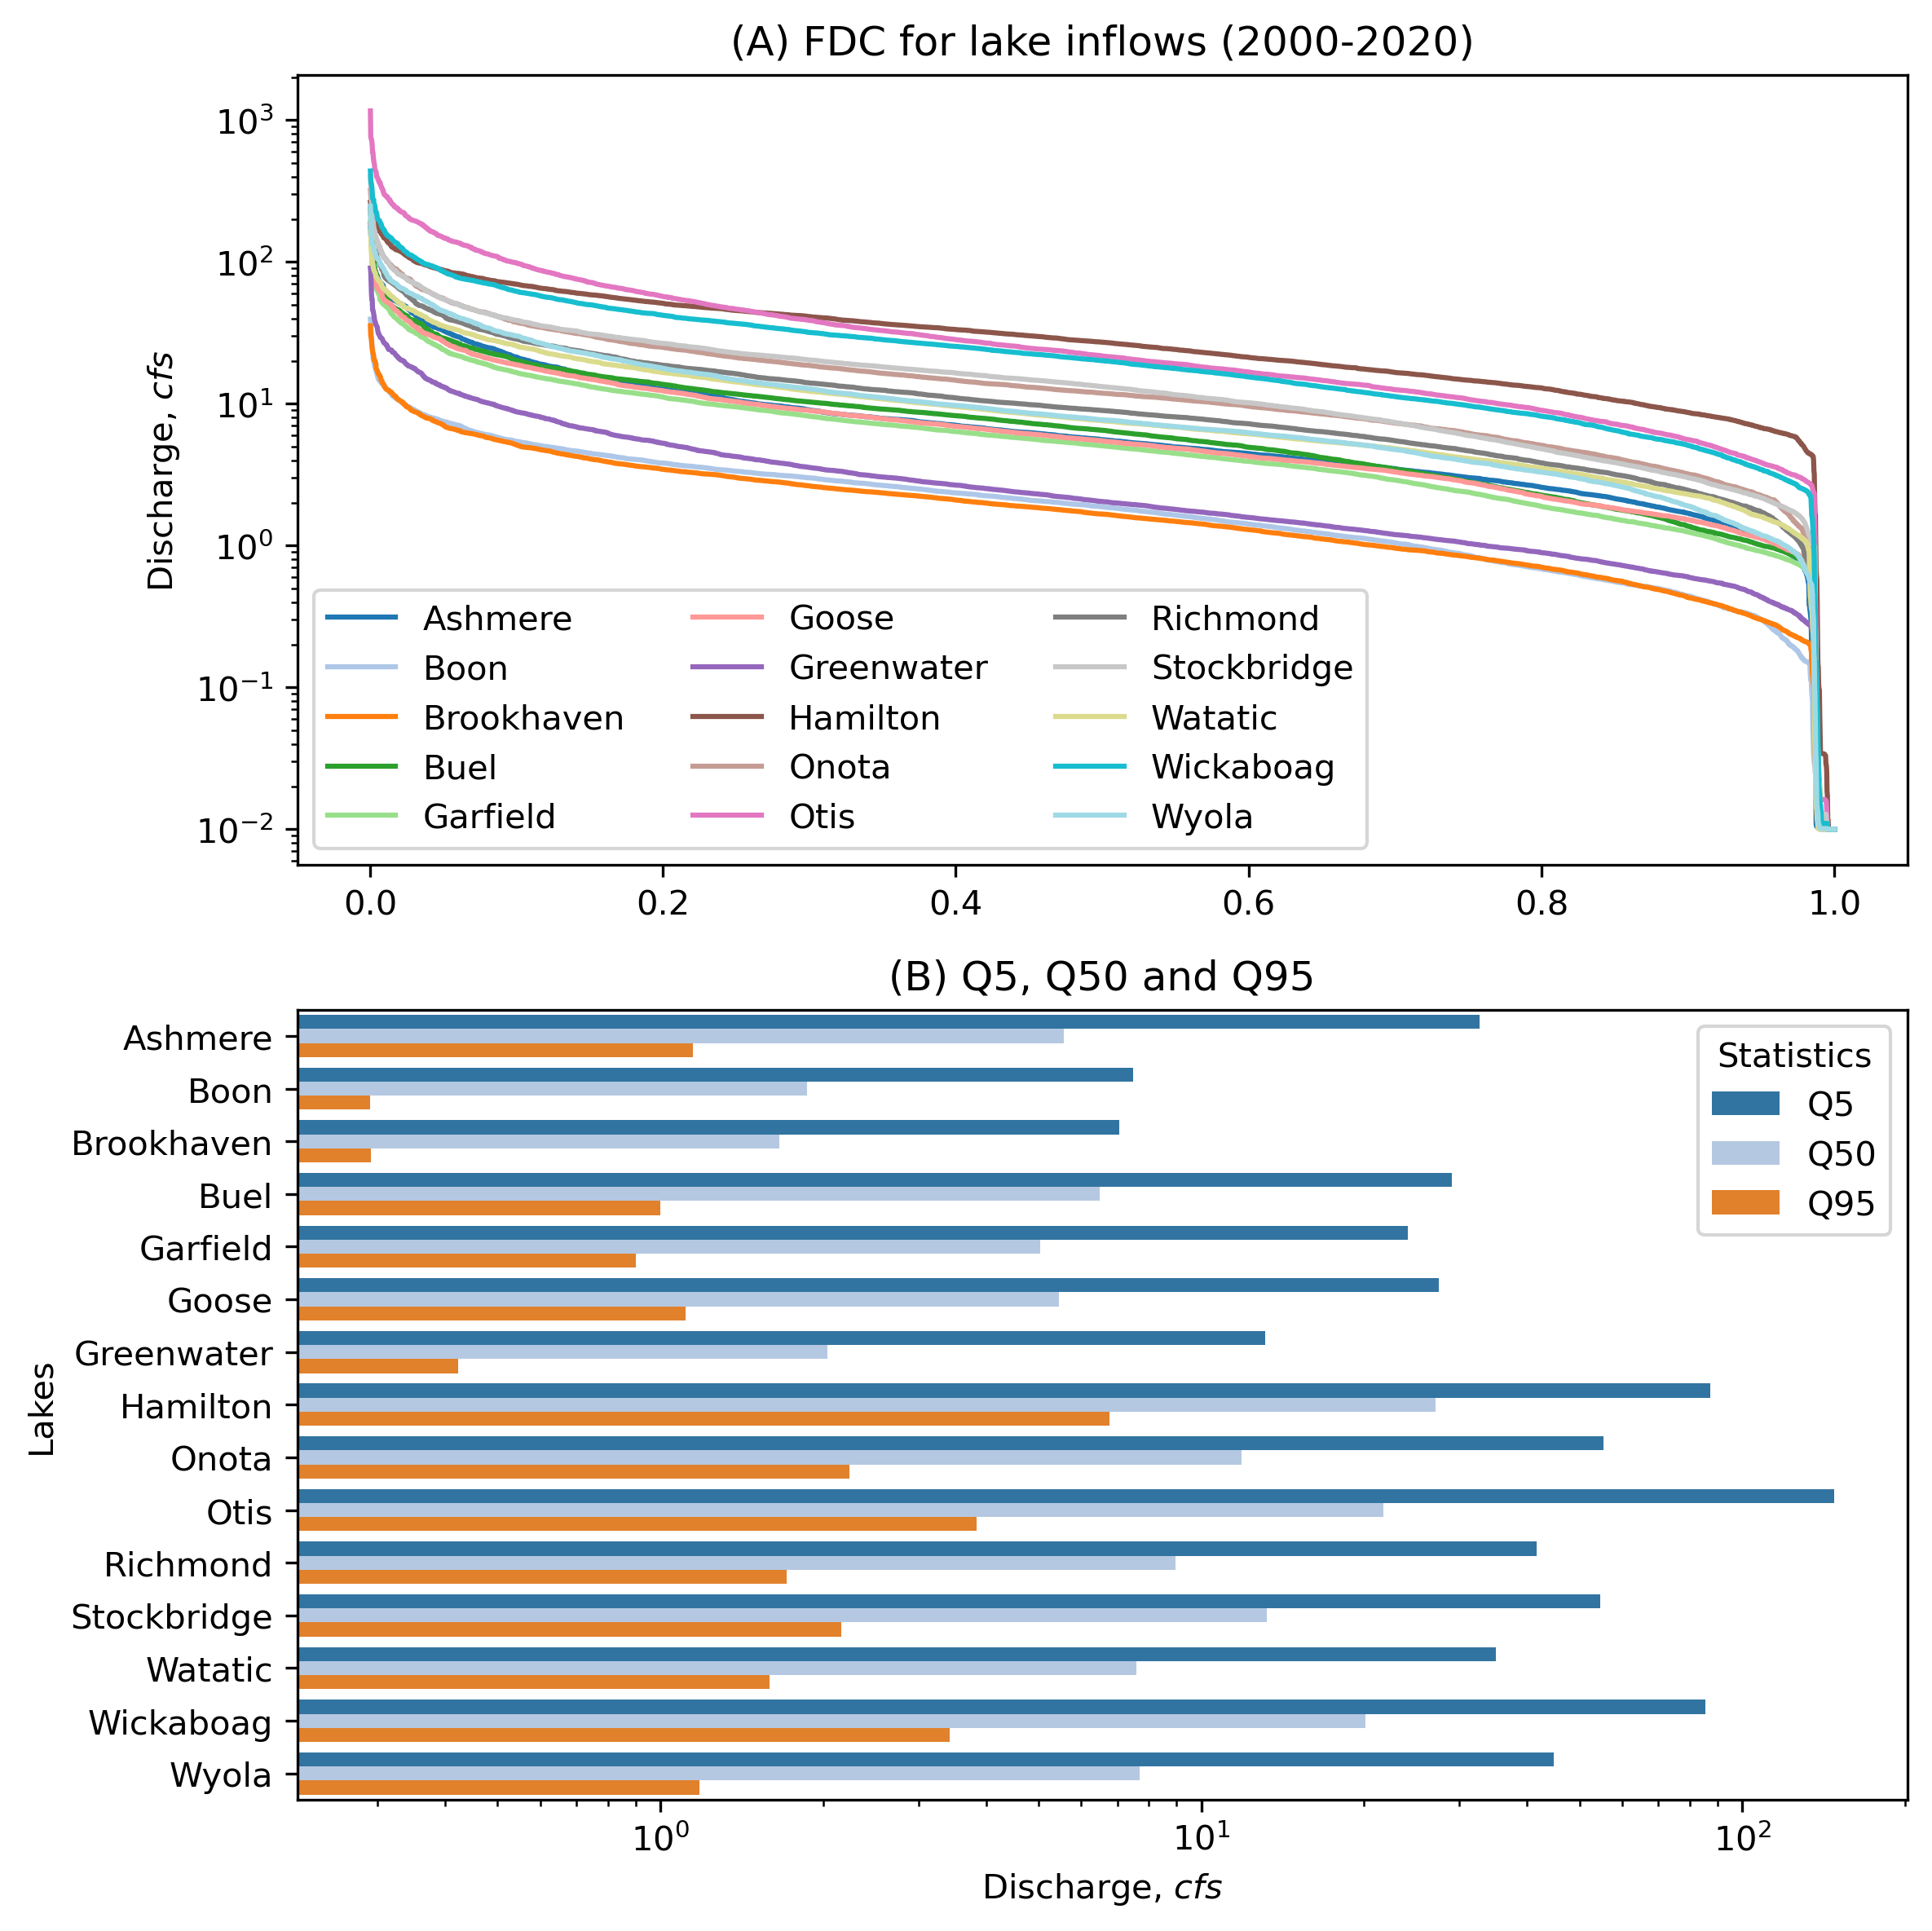

In [13]:
fig_fdc_2, axes = plt.subplots(2,1, figsize = (8,8), dpi = 300)
q5 = []# Q5
q50 = [] # Q50
q95 = [] # q95

colors = [cm.tab20(x) for x in np.linspace(0,1,15)]

for i, n in enumerate(lnames):
    #calculate flow stat
    flow_stat = flow_duration(lakes[n].cgr4j_inflow.values.ravel() *35.3147 + 0.01)
    
    # FDC
    axes[0].plot(flow_stat,
                   label = n,
                   color = colors[i])
    
    q5.append(np.quantile(lakes[n].cgr4j_inflow.values.ravel() * 35.3147, 0.95))
    q50.append(np.quantile(lakes[n].cgr4j_inflow.values.ravel() * 35.3147, 0.5))
    q95.append(np.quantile(lakes[n].cgr4j_inflow.values.ravel() * 35.3147, 0.05))
    
axes[0].legend(ncol = 3)
axes[0].set_yscale('log')
axes[0].set_ylabel('Discharge, $cfs$')
axes[0].set_title('(A) FDC for lake inflows (2000-2020)')


# create a dataframe to plot grouped barplot
q_df = pd.DataFrame([], columns = ['Discharge, $cfs$', 'Statistics'])
q_df['Discharge, $cfs$'] = q5 + q50 + q95
q_df['Statistics'] = ['Q5' for j in range(len(lnames))] + ['Q50' for j in range(len(lnames))] + ['Q95' for j in range(len(lnames))]
q_df['Lakes'] = lnames * 3

# plot bar  plot of the q5, q95, q50
sns.barplot(data = q_df, x = 'Discharge, $cfs$', y = 'Lakes', hue = 'Statistics', ax = axes[1], palette = 'tab20')
axes[1].set_xscale('log')
axes[1].set_title('(B) Q5, Q50 and Q95')

plt.tight_layout()


In [14]:
# fig_fdc_2.savefig("docs/paper_1/inflow_summary_statistics/fdc_q5_50_95.pdf", bbox_inches='tight')

Ashmere   STD =  12.82 high =  10.56 median =  5.58 low = 3.02
Boon   STD =  2.76 high =  3.34 median =  1.88 low = 0.85
Brookhaven   STD =  2.7 high =  3.01 median =  1.67 low = 0.83
Buel   STD =  13.14 high =  11.7 median =  6.5 low = 2.82
Garfield   STD =  10.63 high =  9.5 median =  5.05 low = 2.38
Goose   STD =  11.45 high =  10.35 median =  5.47 low = 2.78
Greenwater   STD =  5.54 high =  4.24 median =  2.04 low = 1.03
Hamilton   STD =  29.06 high =  45.41 median =  27.15 low = 14.64
Onota   STD =  21.72 high =  21.16 median =  11.87 low = 6.21
Otis   STD =  63.82 high =  46.41 median =  21.73 low = 10.75
Richmond   STD =  16.49 high =  16.27 median =  8.97 low = 4.65
Stockbridge   STD =  22.85 high =  22.8 median =  13.2 low = 5.97
Watatic   STD =  12.78 high =  14.23 median =  7.59 low = 4.11
Wickaboag   STD =  33.21 high =  36.76 median =  20.1 low = 9.69
Wyola   STD =  17.03 high =  14.69 median =  7.69 low = 3.93


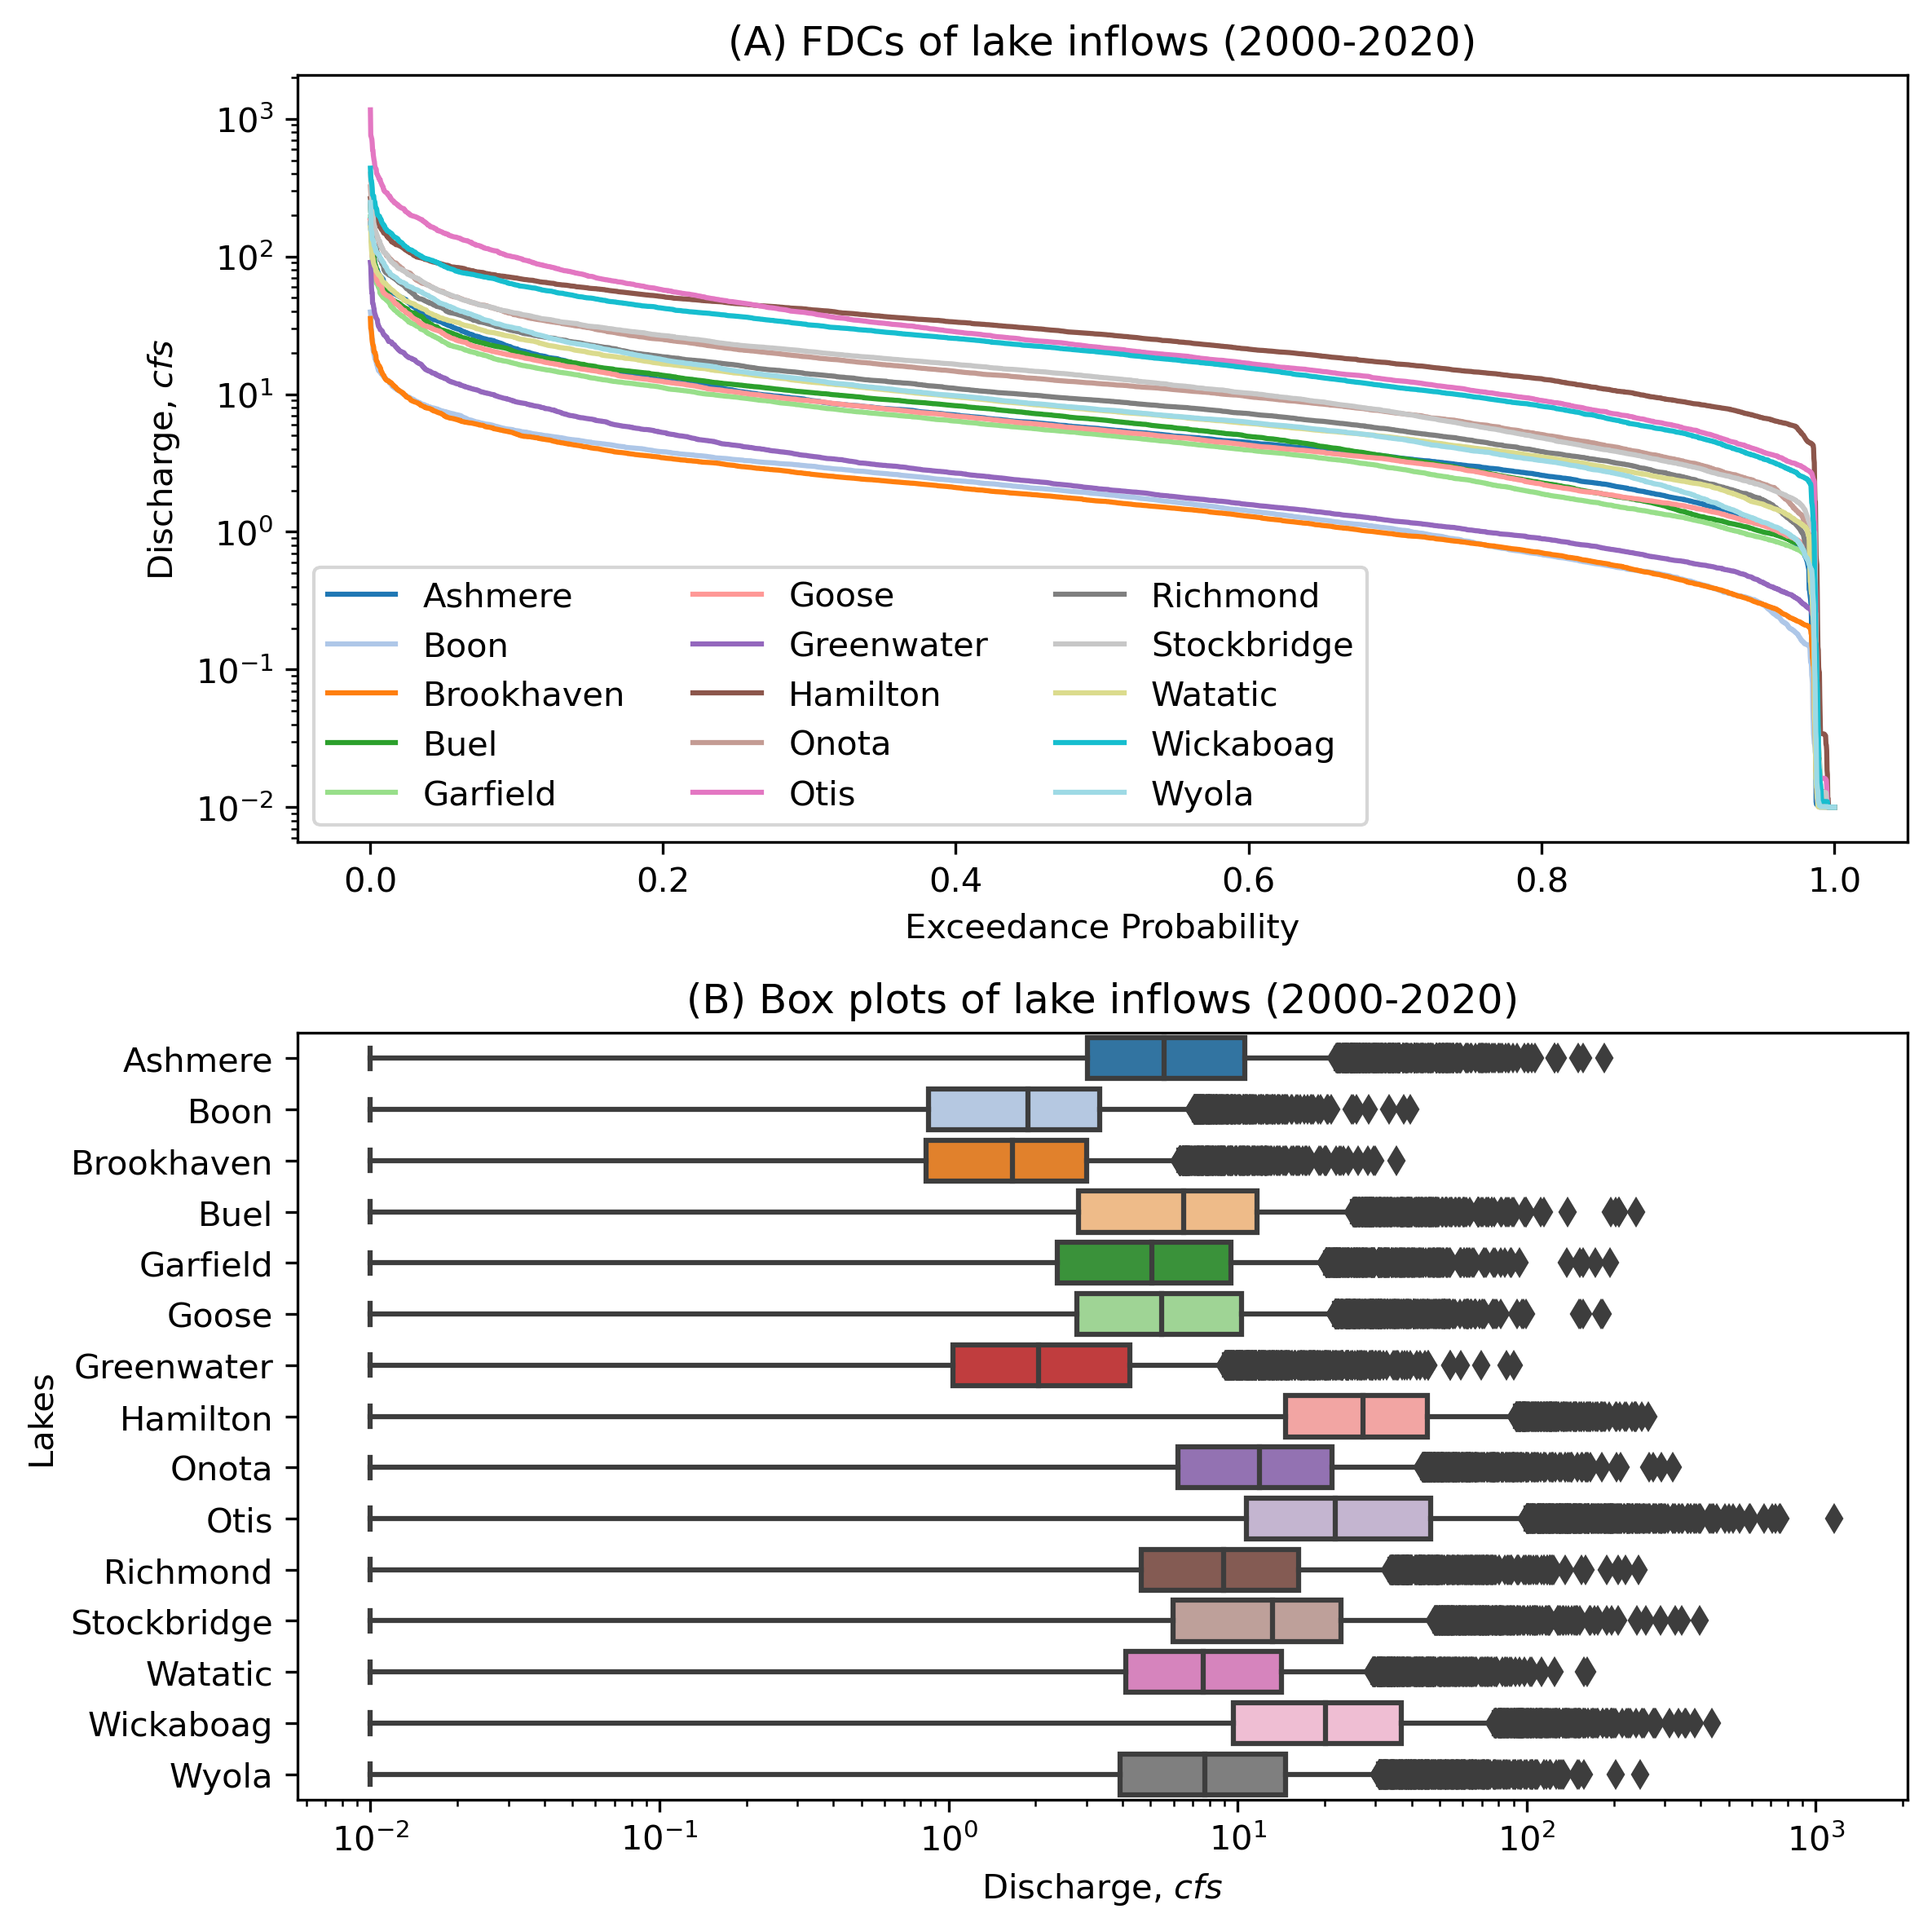

In [46]:
fig_fdc_3, axes = plt.subplots(2,1, figsize = (8,8), dpi = 300)
colors = [cm.tab20(x) for x in np.linspace(0,1,15)]
inflows = pd.DataFrame([])

for i, n in enumerate(lnames):
    #calculate flow stat
    flow_stat = flow_duration(lakes[n].cgr4j_inflow.values.ravel() *35.3147 + 0.01)
    
    # FDC
    axes[0].plot(flow_stat,
                   label = n,
                   color = colors[i])
    
    inflow_df = lakes[n].cgr4j_inflow * 35.3147 + 0.01
    
    print(n, ' ', 'STD = ', round(inflow_df.std()[0], 2),
          # round(np.quantile(inflow_df.values.ravel(),0.75) - np.quantile(inflow_df.values.ravel(),0.25), 2), 
          'high = ', round(np.quantile(inflow_df.values.ravel(),0.75), 2), 
          'median = ', round(inflow_df.median()[0], 2),
         'low =', round(np.quantile(inflow_df.values.ravel(),0.25), 2))
    
    inflow_df['Lakes'] = n
    inflows = pd.concat([inflows, inflow_df], axis = 0)

axes[0].legend(ncol = 3)
axes[0].set_yscale('log')
axes[0].set_xlabel('Exceedance Probability')
axes[0].set_ylabel('Discharge, $cfs$')
axes[0].set_title('(A) FDCs of lake inflows (2000-2020)')


# plot bar  plot of the q5, q95, q50
inflows.columns = ['Discharge, $cfs$', 'Lakes']
sns.boxplot(data = inflows, x = 'Discharge, $cfs$', y = 'Lakes', ax = axes[1], palette = 'tab20')
axes[1].set_xscale('log')
axes[1].set_title('(B) Box plots of lake inflows (2000-2020)')

plt.tight_layout()

In [30]:
# fig_fdc_3.savefig("docs/paper_1/inflow_summary_statistics/fdc_boxplot.pdf", bbox_inches='tight')